<a href="https://colab.research.google.com/github/DavinciB/child_grooming_detector/blob/main/Predator_Identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import xml.etree.ElementTree as ET
import csv
def get_susp_conv_dict(data_path):
    labels_dict = {}
    with open(data_path + 'sci_labels.csv', 'r') as f:
        file = csv.reader(f)
        for row in file:
            labels_dict[row[0]] = row[1]
    return labels_dict

def get_predators_dict(file): 
    all_predators = {}
    with open(file, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            all_predators[row[0]] = 1
    return all_predators
            

def get_features_labels(root, labels_dict, all_predators):
    corpus = []
    labels = []
    for conversation in root:
        if labels_dict[conversation.get('id')] == '0':
            continue
        author_conv_dict = {}
        for message in conversation:
            author = message.find('author').text
            text = message.find('text').text
            if text is not None:
                if author not in author_conv_dict:
                    author_conv_dict[author] = text
                else:
                    author_conv_dict[author] += " " + text 
        for author, conv in author_conv_dict.items():
            corpus.append(conv)
            if author in all_predators:
                labels.append(1)
            else:
                labels.append(-1)
    return corpus, labels

In [4]:
train_data_path = '/content/drive/MyDrive/online-grooming-detector-master/data/svm_training_data/'
training_xml = ET.parse(train_data_path + 'training_data.xml')
train_root = training_xml.getroot()

test_data_path = '/content/drive/MyDrive/online-grooming-detector-master/data/svm_test_data/'
test_data_src = '/content/drive/MyDrive/online-grooming-detector-master/data/pan12-sexual-predator-identification-test-corpus-2012-05-21/'
test_xml = ET.parse(test_data_src + 'pan12-sexual-predator-identification-test-corpus-2012-05-17.xml')
test_root = test_xml.getroot()

pred_train_file_path = '/content/drive/MyDrive/online-grooming-detector-master/data/pan12-sexual-predator-identification-training-corpus-2012-05-01/pan12-sexual-predator-identification-training-corpus-predators-2012-05-01.txt'
pred_test_file_path = '/content/drive/MyDrive/online-grooming-detector-master/data/pan12-sexual-predator-identification-test-corpus-2012-05-21/pan12-sexual-predator-identification-groundtruth-problem1.txt'
train_corpus, train_labels = get_features_labels(train_root, get_susp_conv_dict(train_data_path), get_predators_dict(pred_train_file_path))
test_corpus, test_labels = get_features_labels(test_root, get_susp_conv_dict(test_data_path), get_predators_dict(pred_test_file_path))

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
import numpy as np
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_corpus)
X_test = vectorizer.transform(test_corpus)
X_train = scipy.sparse.csr_matrix(X_train)
y_train = np.array(train_labels)
X_test = scipy.sparse.csr_matrix(X_test)
y_test = np.array(test_labels)

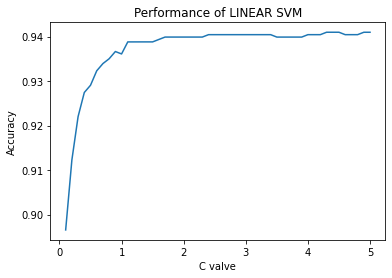

Best performing linear kernel SVM: C=4.3, Acc=0.9409635722679202


In [6]:

from sklearn import svm
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn import metrics
import heapq
import operator
import numpy as np
from mpl_toolkits.mplot3d import axes3d, Axes3D
from sklearn.svm import LinearSVC

num_fold = 10
k_fold = KFold(num_fold, True, 1)
acc = []
for coef_c in np.arange(0.1, 5.1, 0.1):
    acc_arr = np.zeros(num_fold)
    ind = 0
    for train_rows, val_rows in k_fold.split(X_train):
        model = LinearSVC(random_state=0, C=coef_c, loss='squared_hinge', dual=True)
        model.fit(X_train[train_rows], y_train[train_rows])
        pred_y = model.predict(X_train[val_rows])
        acc_arr[ind] = metrics.accuracy_score(y_train[val_rows], pred_y)
        ind += 1
    acc.append([coef_c, np.mean(acc_arr)])
plt.plot([i[0] for i in acc], [i[1] for i in acc])
plt.title("Performance of LINEAR SVM")
plt.xlabel("C valve")
plt.ylabel("Accuracy")
plt.show()
best = heapq.nlargest(1, acc, key=operator.itemgetter(1))[0]
print("Best performing linear kernel SVM: C={}, Acc={}".format(best[0], best[1]))

In [7]:
model = LinearSVC(random_state=0, C=4.3, loss='squared_hinge', dual=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("LSVM-ACCURACY => "+str(metrics.accuracy_score(y_test, y_pred)*100)+str(" %"))

LSVM-ACCURACY => 85.05706134094152 %


In [8]:
import pickle
import datetime

filename = '/content/drive/MyDrive/online-grooming-detector-master/models/PI_SVM.sav'
pickle.dump(model, open(filename, 'wb'))